In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('mcdonalds.csv')

In [5]:
df.columns

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

In [3]:
df.shape

(1453, 15)

In [4]:
df.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


In [9]:
MD_x = df.iloc[:, :11].values  # Select first 11 columns and convert to a NumPy array
MD_x = (MD_x == "Yes").astype(int)    # Convert "Yes" to 1 and "No" to 0
col_means = np.round(MD_x.mean(axis=0), 2)  # Calculate column means and round to 2 decimal places

print(col_means)

[0.55 0.91 0.09 0.87 0.53 0.9  0.6  0.64 0.36 0.2  0.24]


In [11]:
from sklearn.decomposition import PCA

pca = PCA()
MD_pca = pca.fit(MD_x)  # Perform PCA on the matrix

# Summary similar to R's `summary(MD.pca)`
explained_variance = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(MD_pca.explained_variance_ratio_))],
    'Explained Variance Ratio': np.round(MD_pca.explained_variance_ratio_, 4),
    'Cumulative Variance': np.round(np.cumsum(MD_pca.explained_variance_ratio_), 4)
})

print("Explained Variance Summary:")
print(explained_variance)

Explained Variance Summary:
      PC  Explained Variance Ratio  Cumulative Variance
0    PC1                    0.2994               0.2994
1    PC2                    0.1928               0.4922
2    PC3                    0.1330               0.6253
3    PC4                    0.0831               0.7084
4    PC5                    0.0595               0.7679
5    PC6                    0.0503               0.8182
6    PC7                    0.0438               0.8620
7    PC8                    0.0395               0.9016
8    PC9                    0.0368               0.9383
9   PC10                    0.0324               0.9707
10  PC11                    0.0293               1.0000


In [12]:
# Print PCA components similar to `print(MD.pca, digits = 1)`
components = np.round(MD_pca.components_, 1) 
print("\nPCA Components (rounded to 1 decimal place):")
print(components)


PCA Components (rounded to 1 decimal place):
[[-0.5 -0.2 -0.   0.1  0.3 -0.1 -0.3 -0.5  0.3 -0.2  0.4]
 [ 0.4  0.   0.  -0.  -0.1 -0.1 -0.6  0.3  0.6  0.1 -0.1]
 [-0.3 -0.1 -0.  -0.3 -0.8 -0.1 -0.1 -0.3  0.   0.2 -0.1]
 [ 0.1 -0.1  0.2 -0.4  0.3 -0.1  0.1 -0.   0.1  0.8  0.4]
 [-0.3  0.3  0.1 -0.1  0.4  0.1 -0.1 -0.2 -0.   0.3 -0.7]
 [ 0.2 -0.3 -0.4 -0.4  0.2 -0.6 -0.1 -0.1 -0.3 -0.2 -0.2]
 [-0.3 -0.1  0.7 -0.4  0.  -0.1 -0.   0.4 -0.1 -0.3 -0. ]
 [ 0.  -0.1  0.4  0.6 -0.1 -0.6  0.1 -0.1  0.   0.2 -0.2]
 [ 0.6 -0.   0.4 -0.2 -0.   0.2  0.1 -0.6  0.1 -0.2 -0.1]
 [-0.1 -0.7 -0.1 -0.   0.   0.2  0.4  0.1  0.5 -0.  -0.3]
 [ 0.  -0.5  0.1  0.3  0.   0.3 -0.5  0.  -0.5  0.2 -0. ]]


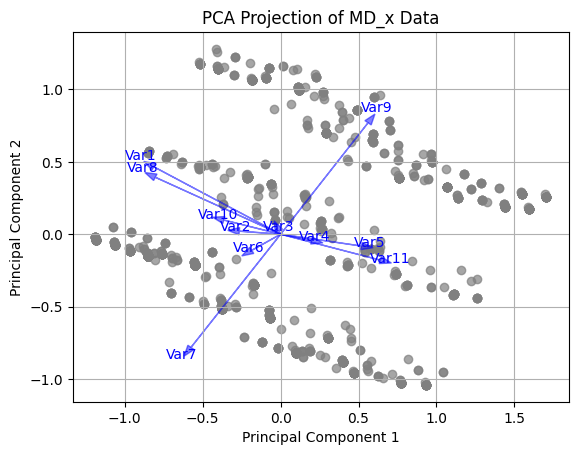

In [13]:
MD_pca = pca.fit_transform(MD_x)  # Perform PCA and transform the data

# Plot the first two principal components with points in grey
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of MD_x Data")

# Project axes (equivalent to projAxes in R)
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, comp1 * max(MD_pca[:, 0]), comp2 * max(MD_pca[:, 1]), 
              color='blue', alpha=0.5, head_width=0.05)
    plt.text(comp1 * max(MD_pca[:, 0]) * 1.1, comp2 * max(MD_pca[:, 1]) * 1.1, 
             f"Var{i+1}", color='blue', ha='center')

plt.grid()
plt.show()

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(1234)

results = []
for k in range(2, 9): 
    best_model = None
    best_score = -1
    
    # Repeat clustering 10 times and take the best (based on inertia or silhouette)
    for i in range(10):
        model = KMeans(n_clusters=k, random_state=i)
        clusters = model.fit_predict(MD_x)
        score = silhouette_score(MD_x, clusters)
        
        if score > best_score:
            best_model = model
            best_score = score
            
    # Store the best model for each k
    results.append((k, best_model, best_score))

# Find the best clustering (highest silhouette score across all k)
best_k, best_model, best_score = max(results, key=lambda x: x[2])

# Optional: relabel clusters if needed based on your requirements
labels = best_model.labels_

/home/saif/.conda/envs/visa/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/saif/.conda/envs/visa/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/saif/.conda/envs/visa/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/saif/.conda/envs/visa/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` wi